Testing a new way of fitting and plotting the emission lines

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
line_tab = Table.read('linsky_lines.tsv', format ='ascii')
#line_tab

In [3]:
lines = line_tab['Wavelength']*10
#len(lines[lines > 1100])

In [4]:
t1data = Table.read('../../common/quicksaves/2MASS-J23062928-0502285_basic.ecsv')

In [5]:
w, f , e = np.array(t1data['WAVELENGTH']), np.array(t1data['FLUX']), np.array(t1data['ERROR'])

In [6]:
cos_cut = (w > 1100) & (w < 1210) | (w > 1220) & (w < 3100) 
w, f, e = w[cos_cut], f[cos_cut], e[cos_cut]

In [7]:
line_data = [1176., 1206.51, 1218.344, 1238.821, 1242.804,
       1334.532, 1335.708, 1351.657,
       1355.598, 1371.292, 1393.755, 1401.156, 1402.77 , 1548.195,
       1550.77 , 1561.   , 1643.   , 1666.153, 1670.787, 2795.523, 2802.697] #lines for which data exists

In [8]:

model_lines = [1206.51, 1218.344, 1238.821, 1242.804,
       1334.532, 1335.708, 1351.657,
       1355.598, 1371.292, 1393.755, 1401.156, 1402.77 , 1548.195, 1550.77 , 1561.   , 1643.   , 1666.153, 1670.787]#, 2795.523, 2802.697]


In [9]:
"""fitter = fitting.SLSQPLSQFitter()
#fitter = fitting.LevMarLSQFitter()

smooth = 5
f1 = convolve(f,Box1DKernel(smooth))
e1 = convolve(e,Box1DKernel(smooth))/smooth**0.5


gg_init = models.Polynomial1D(2)
dv = -56.3*u.km/u.s

for line in ciii_1175:
    li = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA))
    gg_init += models.Gaussian1D(1e-16, li.value,0.1)

for line in model_lines:
    li = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA))
    gg_init += models.Gaussian1D(1e-16, li.value,0.1)    
    
gg_fit = fitter(gg_init, w, f1, weights=1/e1, maxiter=10000)"""

'fitter = fitting.SLSQPLSQFitter()\n#fitter = fitting.LevMarLSQFitter()\n\nsmooth = 5\nf1 = convolve(f,Box1DKernel(smooth))\ne1 = convolve(e,Box1DKernel(smooth))/smooth**0.5\n\n\ngg_init = models.Polynomial1D(2)\ndv = -56.3*u.km/u.s\n\nfor line in ciii_1175:\n    li = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA))\n    gg_init += models.Gaussian1D(1e-16, li.value,0.1)\n\nfor line in model_lines:\n    li = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA))\n    gg_init += models.Gaussian1D(1e-16, li.value,0.1)    \n    \ngg_fit = fitter(gg_init, w, f1, weights=1/e1, maxiter=10000)'

Did not work

In [10]:
def gauss_flux(amp, std, off, ae, se, oe):
    """
    Calcualates the flux and error of a Gaussian with amplitude and stddev amp and std, with offset off
    """
    off_err = 0
    if off != 0.0:
        amp += (-1*off)
        off_err = (oe/off)**2
        
    flux = ((2*np.pi)**0.5) * amp * std
    error = flux * (((ae/amp)**2)+((se/std)**2)+off_err)**0.5
    return flux, error

Parameter('amplitude', value=-3.2414530606888114e-17)
1.0891917548877338e-16 2.7256835881371515e-17


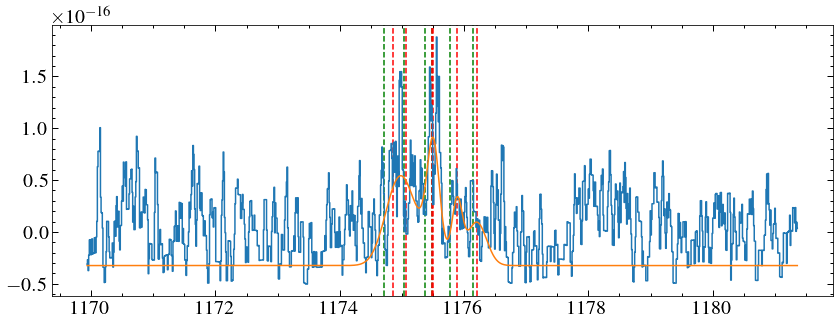

In [11]:
#flux_table
tabline = []
tabflux = []
taberror = []

#ciii
ciii_1175 = [1174.93,1175.26,1175.59,1175.71,1175.99, 1176.37]
#ciii_1175 = [1175.26,1175.59,1175.71,1175.99, 1176.37]
fitter = fitting.LevMarLSQFitter()
smooth=5
dv = -56.3*u.km/u.s
mask = (w > ciii_1175[0] -5) & (w < ciii_1175[-1]+5)
w1, f1, e1 = w[mask], f[mask], e[mask]
f1 = convolve(f1,Box1DKernel(smooth))
e1 = convolve(e1,Box1DKernel(smooth))/smooth**0.5

gg_init= models.Const1D(0)#, bounds={'amplitude':[e-16, 0.5e-16})
for line in ciii_1175:
    li = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA))
    gg_init += models.Gaussian1D(1e-16, li.value,0.1, bounds = {'mean':[li.value-0.2, li.value+0.2], 'stddev':[0.01, 0.2]})
    plt.axvline(li.value, c='g', ls='--')
gg_fit = fitter(gg_init, w1, f1, weights = 1/e1, maxiter=100000)
#fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
[plt.axvline(gg_fit[i+1].mean.value, c='r', ls='--') for i in range(len(ciii_1175))]

plt.step(w1, f1, where='mid')
plt.plot(w1, gg_fit(w1))
#print(gg_fit)

amps1 = [gg_fit[i+1].amplitude.value for i in range(len(ciii_1175))]
means1 = [gg_fit[i+1].mean.value for i in range(len(ciii_1175))]
stds1 = [gg_fit[i+1].stddev.value for i in range(len(ciii_1175))]
offs1 = np.full(len(ciii_1175), gg_fit[0].amplitude)
print(gg_fit[0].amplitude)

lines_table1 = Table([amps1, means1, stds1, offs1], names =['Amplitude', 'Mean', 'Stddev', 'Offset'])
ascii.write(lines_table1, 'ciii1176_lines_for_model.ecsv', format='ecsv', overwrite=True)     

flux_range = [1174.5, 1176.5]
bk_range = [1173, 1174, 1177, 1178]
cflux = np.trapz(f1[(w1<flux_range[0]) & (w1<flux_range[1])], w1[(w1<flux_range[0]) & (w1<flux_range[1])]) + (-1*offs1[0]) * 3
bk_rms1 = np.sqrt(np.mean(f1[(w1>bk_range[0]) & (w1<bk_range[1])]**2))
bk_rms2 = np.sqrt(np.mean(f1[(w1>bk_range[2]) & (w1<bk_range[3])]**2)) 
cflux_error = np.mean([bk_rms1, bk_rms2]) * (2/2)
print (cflux, cflux_error)

tabline.append(1174)
tabflux.append(cflux)
taberror.append(cflux_error)

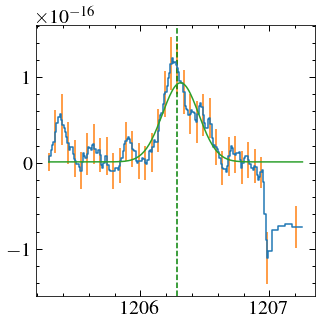

1206.51
3.197456063957699e-17 5.649204077132318e-17


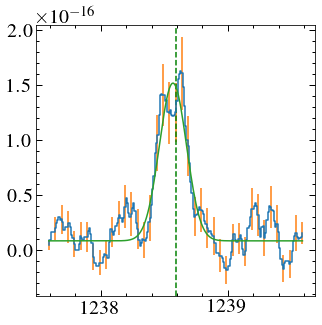

1238.821
3.6062781033925783e-17 6.1165092404635956e-18


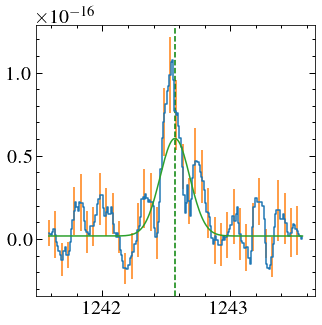

1242.804
1.6476392824823626e-17 9.992940169584001e-18


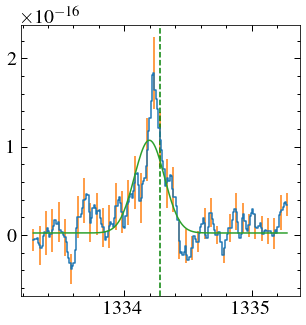

1334.532
3.033875818475514e-17 2.0510084125235615e-17


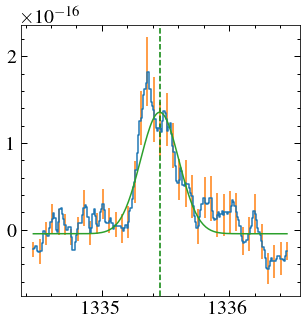

1335.708
5.470844709471302e-17 1.8993361616382556e-17


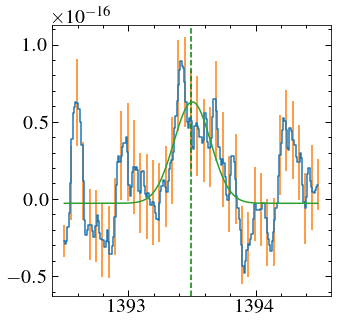

1393.755
2.4827893489081425e-17 1.8970890177037647e-17


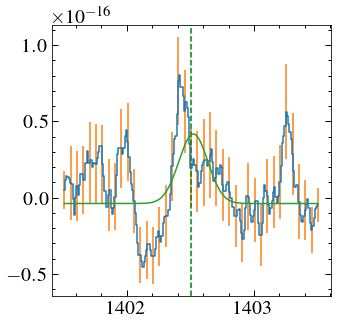

1402.77
1.4129820796684494e-17 7.58597175787411e-18


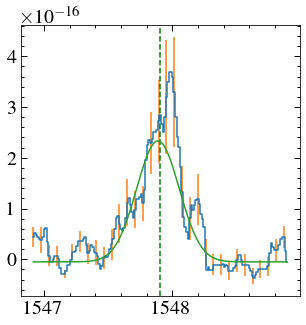

1548.195
1.0146334550676221e-16 4.584385111168377e-17


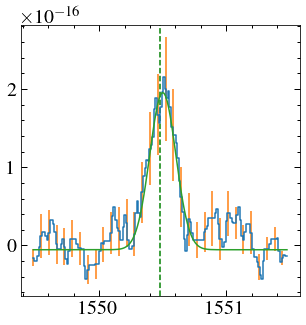

1550.77
5.285114414830972e-17 1.660033936484001e-17
0.12865253547773936


In [12]:

model_lines = [1206.51, 1218.344, 1238.821, 1242.804,
       1334.532, 1335.708, 1351.657,
       1355.598, 1371.292, 1393.755, 1401.156, 1402.77 , 1548.195, 1550.77 , 1561.   , 1643.   , 1666.153, 1670.787]#, 2795.523, 2802.697]

detected_lines = [1206.51, 1238.821, 1242.804,
       1334.532, 1335.708, 1393.755, 1402.77 , 1548.195,
       1550.77]#, 2795.523]

stds = []
amps = []
means = []
offs = []

for line in detected_lines:
    smooth=10
    dv = -56.3*u.km/u.s
    li = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value
    mask = (w > li -1) & (w < li+1)
    w1, f1, e1 = w[mask], f[mask], e[mask]
    f1 = convolve(f1,Box1DKernel(smooth))
    e1 = convolve(e1,Box1DKernel(smooth))/smooth**0.5

    gg_init= models.Const1D(0)
    
    #li = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA))
    bounds1 = {'mean':[li-0.5, li+0.5], 'stddev':[0.005, 0.2], 'amplitude':[0, 5e-16]}
    bounds2 = {'amplitude':[0, 10e-16]}
    bounds3 = {'mean':[li-0.5, li+0.5], 'stddev':[0.005, 0.2]}
    gg_init += models.Gaussian1D(1e-16, li ,0.1)#, bounds = bounds2 )
    
    gg_fit = fitter(gg_init, w1, f1, weights = 1/e1, maxiter=10000)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
   # [plt.axvline(gg_fit[i+1].mean.value, c='r', ls='--') for i in range(len(ciii_1175))]

    plt.figure(figsize=(5,5))
    plt.axvline(li, c='g', ls='--')
    plt.step(w1, f1, where='mid')
    plt.errorbar(w1[::5], f1[::5], yerr=e1[::5], ls='none')
    plt.plot(w1, gg_fit(w1))
    plt.show()
    
    print(line)
    off, oe = gg_fit[0].amplitude, fit_e[0]
    amp, ae = gg_fit[1].amplitude, fit_e[1],
    std, se = gg_fit[1].stddev, fit_e[2]
    f_l, e_l = gauss_flux(amp, std, off, ae, se, oe)
    print(f_l, e_l)
    
    stds.append(gg_fit[1].stddev.value)
    amps.append(gg_fit[1].amplitude.value)
    means.append(gg_fit[1].mean.value)
    offs.append(gg_fit[0].amplitude.value)

    
    tabline.append(line)
    tabflux.append(f_l)
    taberror.append(e_l)
print(np.mean(stds))    
#lines_table = Table([amps, means, stds, offs], names =['Amplitude', 'Mean', 'Stddev', 'Offset'])
#ascii.write(lines_table, 'emmision_lines_for_model.ecsv', format='ecsv', overwrite=True) 
    #print(gg_fit)

   # amps1 = [gg_fit[i+1].amplitude.value for i in range(len(ciii_1175))]
   # means1 = [gg_fit[i+1].mean.value for i in range(len(ciii_1175))]
   # stds1 = [gg_fit[i+1].stddev.value for i in range(len(ciii_1175))]
   # offs1 = np.full(len(ciii_1175), gg_fit[0].amplitude)

   # lines_table1 = Table([amps1, means1, stds1, offs1], names =['Amplitude', 'Mean', 'Stddev', 'Offset'])
   # ascii.write(lines_table1, 'ciii1176_lines_for_model.ecsv', format='ecsv', overwrite=True)     

    #flux_range = [1174, 1177]
    #bk_range = [1173, 1174, 1177, 1178]
    #cflux = np.trapz(f1[(w1<flux_range[0]) & (w1<flux_range[1])], w1[(w1<flux_range[0]) & (w1<flux_range[1])]) + (-1*offs1[0]) * 3
    #bk_rms1 = np.sqrt(np.mean(f1[(w1>bk_range[0]) & (w1<bk_range[1])]**2))
    #bk_rms2 = np.sqrt(np.mean(f1[(w1>bk_range[2]) & (w1<bk_range[3])]**2)) 
    #cflux_error = np.mean([bk_rms1, bk_rms2]) * (3/2)
  #  print (cflux, cflux_error)


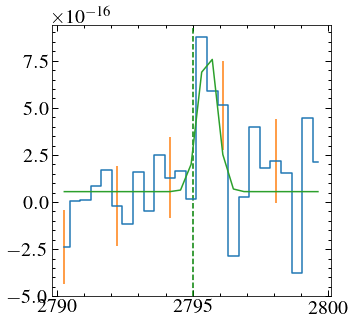

2795.523
6.167664135886777e-16 3.2426355281658146e-17
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const1D(amplitude=0.)>

    [1]: <Gaussian1D(amplitude=0., mean=2802.73029421, stddev=0.33291155)>
Parameters:
         amplitude_0      amplitude_1       mean_1            stddev_1     
    --------------------- ----------- ------------------ ------------------
    7.178965169056808e-17         0.0 2802.7302942076367 0.3329115458296421
2802.697
3.381502669931951e-16


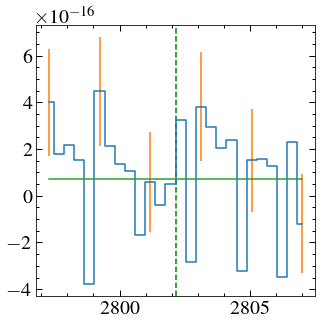

In [39]:
#and the mg ii lines
mglines = [2795.523, 2802.697]
for i, line in enumerate(mglines):
    smooth=10
    dv = -56.3*u.km/u.s
    li = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value
    mask = (w > li -5) & (w < li+5)
    w1, f1, e1 = w[mask], f[mask], e[mask]
    #f1 = convolve(f1,Box1DKernel(smooth))
    #e1 = convolve(e1,Box1DKernel(smooth))/smooth**0.5

    gg_init= models.Const1D(0)
    if i == 0:
    
        #li = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA))
        bounds1 = {'mean':[li-0.5, li+0.5], 'stddev':[0.005, 0.2], 'amplitude':[0, 5e-16]}
        bounds2 = {'amplitude':[0, 10e-16]}
        bounds3 = {'mean':[li-0.5, li+0.5], 'stddev':[0.005, 0.2]}
        gg_init += models.Gaussian1D(1e-16, li ,0.1)#, bounds = bounds2 )

        gg_fit = fitter(gg_init, w1, f1, weights = 1/e1, maxiter=10000)
       # fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
       # [plt.axvline(gg_fit[i+1].mean.value, c='r', ls='--') for i in range(len(ciii_1175))]

        plt.figure(figsize=(5,5))
        plt.axvline(li, c='g', ls='--')
        plt.step(w1, f1, where='mid')
        plt.errorbar(w1[::5], f1[::5], yerr=e1[::5], ls='none')
        plt.plot(w1, gg_fit(w1))
        plt.show()

        print(line)
        off, oe = gg_fit[0].amplitude, fit_e[0]
        amp, ae = gg_fit[1].amplitude, fit_e[1],
        std, se = gg_fit[1].stddev, fit_e[2]
        f_l, e_l = gauss_flux(amp, std, off, ae, se, oe)
        print(f_l, e_l)

        mean1 = gg_fit[1].mean.value
        std1 = gg_fit[1].stddev.value
        stds.append(gg_fit[1].stddev.value)
        amps.append(gg_fit[1].amplitude.value)
        means.append(gg_fit[1].mean.value)
        offs.append(gg_fit[0].amplitude.value)

      #  tabline.append(line)
       # tabflux.append(f_l)
       # taberror.append(e_l)

    if i == 1:
        
        

        gg_init += models.Gaussian1D(1e-16, mean1+np.diff(mglines)[0]  ,std1, fixed=dict(mean=True, stddev=True), bounds= dict(amplitude=[0, 1e-14]))
        gg_fit = fitter(gg_init, w1, f1, weights = 1/e1, maxiter=100000)
        #fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
       # [plt.axvline(gg_fit[i+1].mean.value, c='r', ls='--') for i in range(len(ciii_1175))]
        print(gg_fit)

        plt.figure(figsize=(5,5))
        plt.axvline(li, c='g', ls='--')
        plt.step(w1, f1, where='mid')
        plt.errorbar(w1[::5], f1[::5], yerr=e1[::5], ls='none')
        plt.plot(w1, gg_fit(w1))
     

        print(line)
        off = gg_fit[0].amplitude

        fwhm = std1*2.33
        fmask = (w1 > li-fwhm) & (w1 < li+fwhm)
        fluxlim = np.sqrt(np.mean(f1[fmask]**2))*2*fwhm
        print(fluxlim)
        #plt.axvline(li-fwhm)
        #plt.axvline(li+fwhm)
        plt.show()

      #  tabline.append(line)
       # tabflux.append(-1*fluxlim)
       # taberror.append(0)
    
    
sav_lines = detected_lines = [1206.51, 1238.821, 1242.804,
       1334.532, 1335.708, 1393.755, 1402.77 , 1548.195,
       1550.77, 2795.523]     
#lines_table = Table([sav_lines, amps, means, stds, offs], names =['Line','Amplitude', 'Mean', 'Stddev', 'Offset'])
#ascii.write(lines_table, 'emision_lines_for_model.ecsv', format='ecsv', overwrite=True) 

In [14]:
#upper limits
non_detect = np.array([1351.657, 1355.598, 1371.292, 1401.156, 1561.   , 1643.   , 1666.153, 1670.787])
fwhm = 0.12*2.33
for line in non_detect:
    smooth=10
    dv = -56.3*u.km/u.s
    li = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value
    mask = (w > li -5) & (w < li+5)
    w1, f1, e1 = w[mask], f[mask], e[mask]
    f1 = convolve(f1,Box1DKernel(smooth))
    e1 = convolve(e1,Box1DKernel(smooth))/smooth**0.5
    #fwhm = std1*2.33
    fmask = (w1 > li-fwhm) & (w1 < li+fwhm)
    fluxlim = np.sqrt(np.mean(f1[fmask]**2))*2*fwhm
    print(line)
    print(fluxlim)
  
    tabline.append(line)
    tabflux.append(-1*fluxlim)
    taberror.append(0)
    
    
    
                       

1351.657
9.473484712804227e-18
1355.598
1.3807150467405006e-17
1371.292
1.2274017355839714e-17
1401.156
7.525336920654258e-18
1561.0
1.770991641775119e-17
1643.0
2.6404104427956293e-17
1666.153
3.54168700919039e-17
1670.787
4.509981169711479e-17


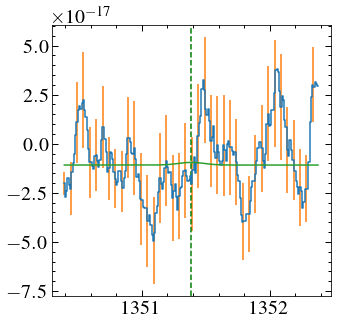

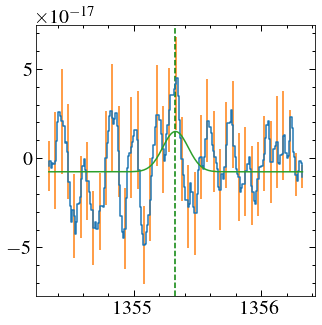

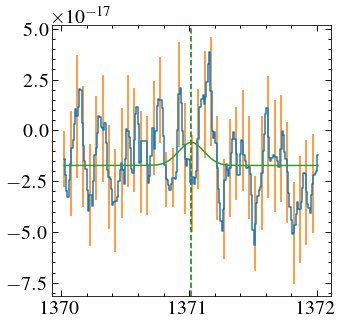

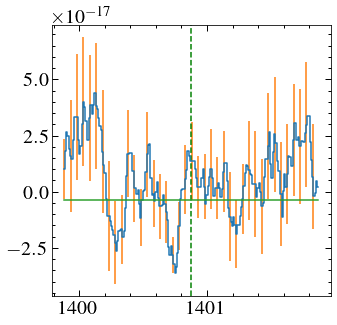

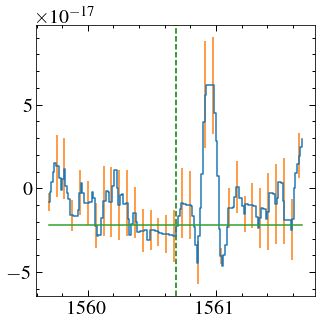

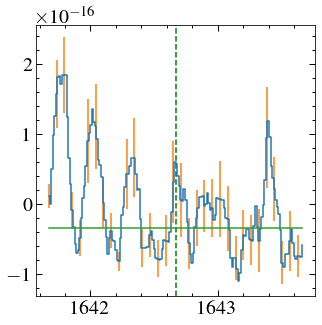

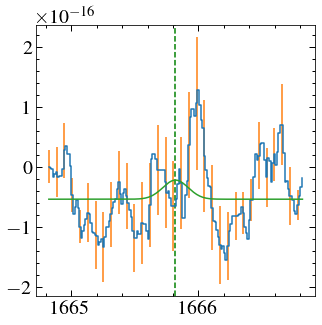

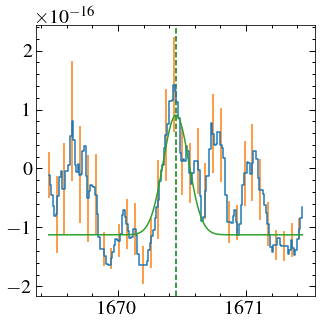

[3.0562769367582717e-18, 7.57781816456334e-18, 7.169927533957134e-18, 1.7720227527898008e-18, 6.181526739312638e-18, 1.0990866767369308e-17, 2.150157916342996e-17, 7.914229615112439e-17]
1351.657 3.056276936758272
1355.598 7.5778181645633405
1371.292 7.169927533957134
1401.156 1.7720227527898007
1561.0 6.1815267393126385
1643.0 10.990866767369308
1666.153 21.501579163429962
1670.787 79.1422961511244


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [53]:
#upper limits with gaussians
#stds = []
#amps = []
#means = []
#offs = []

uplims = []

for line in non_detect:
    smooth=10
    dv = -60*u.km/u.s
    li = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value
    mask = (w > li -1) & (w < li+1)
    w1, f1, e1 = w[mask], f[mask], e[mask]
    f1 = convolve(f1,Box1DKernel(smooth))
    e1 = convolve(e1,Box1DKernel(smooth))/smooth**0.5

    gg_init= models.Const1D(0)
    
    #li = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA))
    bounds1 = {'mean':[li-0.5, li+0.5], 'stddev':[0.005, 0.2], 'amplitude':[0, 5e-16]}
    bounds2 = {'amplitude':[0, 10e-16]}
    bounds3 = {'mean':[li-0.5, li+0.5], 'stddev':[0.005, 0.2]}
 #   gg_init += models.Gaussian1D(1e-16, li ,0.1)#, bounds = bounds2 )
    gg_init = models.Const1D(0)+  models.Gaussian1D(1e-16, li ,0.1, bounds=dict(amplitude=[0, 1e-15]), fixed=dict(mean=True, stddev=True))
    
    gg_fit = fitter(gg_init, w1, f1, weights = 1/e1, maxiter=1000000)
    
   # [plt.axvline(gg_fit[i+1].mean.value, c='r', ls='--') for i in range(len(ciii_1175))]

    plt.figure(figsize=(5,5))
    plt.axvline(li, c='g', ls='--')
    plt.step(w1, f1, where='mid')
    plt.errorbar(w1[::5], f1[::5], yerr=e1[::5], ls='none')
    plt.plot(w1, gg_fit(w1))
    plt.show()
    
   # print(line)
   # print(li)
   # print(gg_fit[1].amplitude)
    #print(fitter.fit_info)
    if fitter.fit_info['param_cov'] is not None:
        fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
        #print(fit_e)
      
        off, oe = gg_fit[0].amplitude, fit_e[0]
        amp, ae = gg_fit[1].amplitude, fit_e[1],
       # print(amp.value, ae)
        std, se = gg_fit[1].stddev, 0
        f_l, e_l = gauss_flux(amp, std, off, ae, se, oe)
      #  print(f_l, e_l)
        error = f_l * ((ae/amp)**2)
     #   print(error)
        
        uplims.append(f_l)
    else:
        gg_init = models.Const1D(0)
        gg_fit = fitter(gg_init, w1, f1, weights = 1/e1, maxiter=1000000)
        fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
        off, oe = gg_fit.amplitude, fit_e[0]
        fl= (2.335*0.1)*((3*oe)-off) 
        uplims.append(fl)
        
print(uplims)
for line, ul in zip(non_detect, uplims):
    print(line, ul*1e18)
        
    #stds.append(gg_fit[1].stddev.value)
    #amps.append(gg_fit[1].amplitude.value)
    #means.append(gg_fit[1].mean.value)
    #offs.append(gg_fit[0].amplitude.value)

   # .2426355281658146e-17
tabline.append(line)
tabflux.append(f_l)
taberror.append(e_l)
#print(np.mean(stds))    

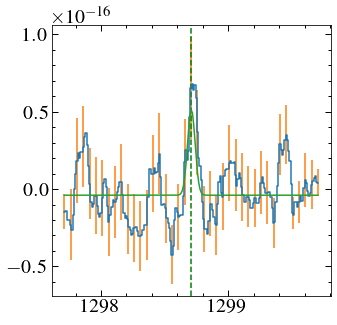

4.3969820691636234e-18 3.468285353686183e-18


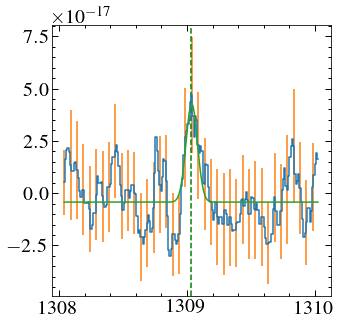

5.727531846965833e-18 2.6219289704076484e-18
1264.73 1.0670125239339006
1298.95 4.396982069163624
1309.28 5.7275318469658325
1391.08 2.5517793440605616
1526.71 3.2199201764364966
1533.43 3.174996919350661
1766.39 44.335867012950885


In [62]:
#peacock + lines
plines = [1264.73, 1298.95,1309.28, 1391.08, 1526.71,  1533.43, 1766.39]
smooth=10
dv = -56.3*u.km/u.s
 
pflux = []    
for i, line in enumerate(plines):

    li = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value
    mask = (w > li -1) & (w < li+1)
    w1, f1, e1 = w[mask], f[mask], e[mask]
    f1 = convolve(f1,Box1DKernel(smooth))
    e1 = convolve(e1,Box1DKernel(smooth))/smooth**0.5
    if i in [1,2]:

        gg_init = models.Const1D(0)

        gg_init += models.Gaussian1D(1e-16, li ,0.1)#, bounds = bounds2 )

        gg_fit = fitter(gg_init, w1, f1, weights = 1/e1, maxiter=10000)
        fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
      

        plt.figure(figsize=(5,5))
        plt.axvline(li, c='g', ls='--')
        plt.step(w1, f1, where='mid')
        plt.errorbar(w1[::5], f1[::5], yerr=e1[::5], ls='none')
        plt.plot(w1, gg_fit(w1))
        plt.show()
      #  print(gg_fit)
       # print(line)
        off, oe = gg_fit[0].amplitude, fit_e[0]
        amp, ae = gg_fit[1].amplitude, fit_e[1],
        std, se = gg_fit[1].stddev, fit_e[2]
        f_l, e_l = gauss_flux(amp, std, off, ae, se, oe)
        print(f_l, e_l)
        #tabline.append(line)
        #tabflux.append(f_l)
        #taberror.append(e_l)
        pflux.append(f_l)
        
        
    else:
        gg_init = models.Const1D(0)

        #gg_init += models.Gaussian1D(1e-16, li ,0.1)#, bounds = bounds2 )

        gg_fit = fitter(gg_init, w1, f1, weights = 1/e1, maxiter=10000)
        fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
      
        off, oe = gg_fit.amplitude, fit_e[0]
        fl= (2.335*0.1)*((3*oe)-off) 
        pflux.append(fl)
        #print(line)
        #print(fluxlim)
   #     tabline.append(line)
    #    tabflux.append(-1*fluxlim)
     #   taberror.append(0)
for line, ul in zip(plines, pflux):
    print(line, ul*1e18)

In [17]:
args = np.argsort(tabline)
tabline, tabflux, taberror = np.array(tabline)[args], np.array(tabflux)[args], np.array(taberror)[args]
for a, b, c in zip(tabline, tabflux, taberror):
    print(a,b,c)

1174.0 1.0891917548877338e-16 2.7256835881371515e-17
1206.51 3.197456063957699e-17 5.649204077132318e-17
1238.821 3.6062781033925783e-17 6.1165092404635956e-18
1242.804 1.6476392824823626e-17 9.992940169584001e-18
1264.73 -4.2144211943382585e-18 0.0
1298.95 4.3969820691636234e-18 3.468285353686183e-18
1309.28 5.727531846965833e-18 2.6219289704076484e-18
1334.532 3.033875818475514e-17 2.0510084125235615e-17
1335.708 5.470844709471302e-17 1.8993361616382556e-17
1351.657 -9.473484712804227e-18 0.0
1355.598 -1.3807150467405006e-17 0.0
1371.292 -1.2274017355839714e-17 0.0
1391.08 -1.2609159211601161e-17 0.0
1393.755 2.4827893489081425e-17 1.8970890177037647e-17
1401.156 -7.525336920654258e-18 0.0
1402.77 1.4129820796684494e-17 7.58597175787411e-18
1526.71 -7.33079665875012e-18 0.0
1533.43 -1.4654852663648865e-17 0.0
1548.195 1.0146334550676221e-16 4.584385111168377e-17
1550.77 5.285114414830972e-17 1.660033936484001e-17
1561.0 -1.770991641775119e-17 0.0
1643.0 -2.6404104427956293e-17 0.0
16

In [18]:
names = ['C', 'Si', 'N', 'N', 'Si', 'Si','Si', 'C', 'C', 'C', 'O', 'O', 'Fe', 'Si', 'C', 'Si', 'Si', 'Si', 'C', 'C', 'C', 'He','O', 'Al', 'Al', 'Mg', 'Mg']
ions = ['iii', 'iii', 'v', 'v', 'ii','ii','ii','ii','ii','i','i','v','ii', 'iv', 'i', 'iv', 'ii', 'ii','iv', 'iv', 'i', 'ii', 'iii', 'ii', 'i', 'ii', 'ii']


In [19]:
def Round_n_sig_dig(x, n):

    import numpy as np               
    xr = (np.floor(np.log10(np.abs(x)))).astype(int)
    xr=10.**xr*np.around(x/10.**xr,n-1)   
    return xr

In [20]:
for i, name in enumerate(names):
    fi = Round_n_sig_dig(tabflux[i]*1e18, 2)
    if  fi < 0:
        value = '$\leq{0}$'.format((-1*fi))
    else:
        ei = Round_n_sig_dig(taberror[i]*1e18, 2)
        value = '${0}\pm{1}$'.format(fi, ei)
    print ('\ion{{{}}}{{{}}} & {} & '.format(names[i], ions[i], tabline[i])+value+' \\\ ' )  

\ion{C}{iii} & 1174.0 & $110.00000000000001\pm27.0$ \\ 
\ion{Si}{iii} & 1206.51 & $32.0\pm56.0$ \\ 
\ion{N}{v} & 1238.821 & $36.0\pm6.1$ \\ 
\ion{N}{v} & 1242.804 & $16.0\pm10.0$ \\ 
\ion{Si}{ii} & 1264.73 & $\leq4.2$ \\ 
\ion{Si}{ii} & 1298.95 & $4.4\pm3.5$ \\ 
\ion{Si}{ii} & 1309.28 & $5.7\pm2.6$ \\ 
\ion{C}{ii} & 1334.532 & $30.0\pm21.0$ \\ 
\ion{C}{ii} & 1335.708 & $55.0\pm19.0$ \\ 
\ion{C}{i} & 1351.657 & $\leq9.5$ \\ 
\ion{O}{i} & 1355.598 & $\leq14.0$ \\ 
\ion{O}{v} & 1371.292 & $\leq12.0$ \\ 
\ion{Fe}{ii} & 1391.08 & $\leq13.0$ \\ 
\ion{Si}{iv} & 1393.755 & $25.0\pm19.0$ \\ 
\ion{C}{i} & 1401.156 & $\leq7.5$ \\ 
\ion{Si}{iv} & 1402.77 & $14.0\pm7.6$ \\ 
\ion{Si}{ii} & 1526.71 & $\leq7.3$ \\ 
\ion{Si}{ii} & 1533.43 & $\leq15.0$ \\ 
\ion{C}{iv} & 1548.195 & $100.0\pm46.0$ \\ 
\ion{C}{iv} & 1550.77 & $53.0\pm17.0$ \\ 
\ion{C}{i} & 1561.0 & $\leq18.0$ \\ 
\ion{He}{ii} & 1643.0 & $\leq26.0$ \\ 
\ion{O}{iii} & 1666.153 & $\leq35.0$ \\ 
\ion{Al}{ii} & 1670.787 & $\leq45.0$ \\ 
\ion{Al

ok some plots:

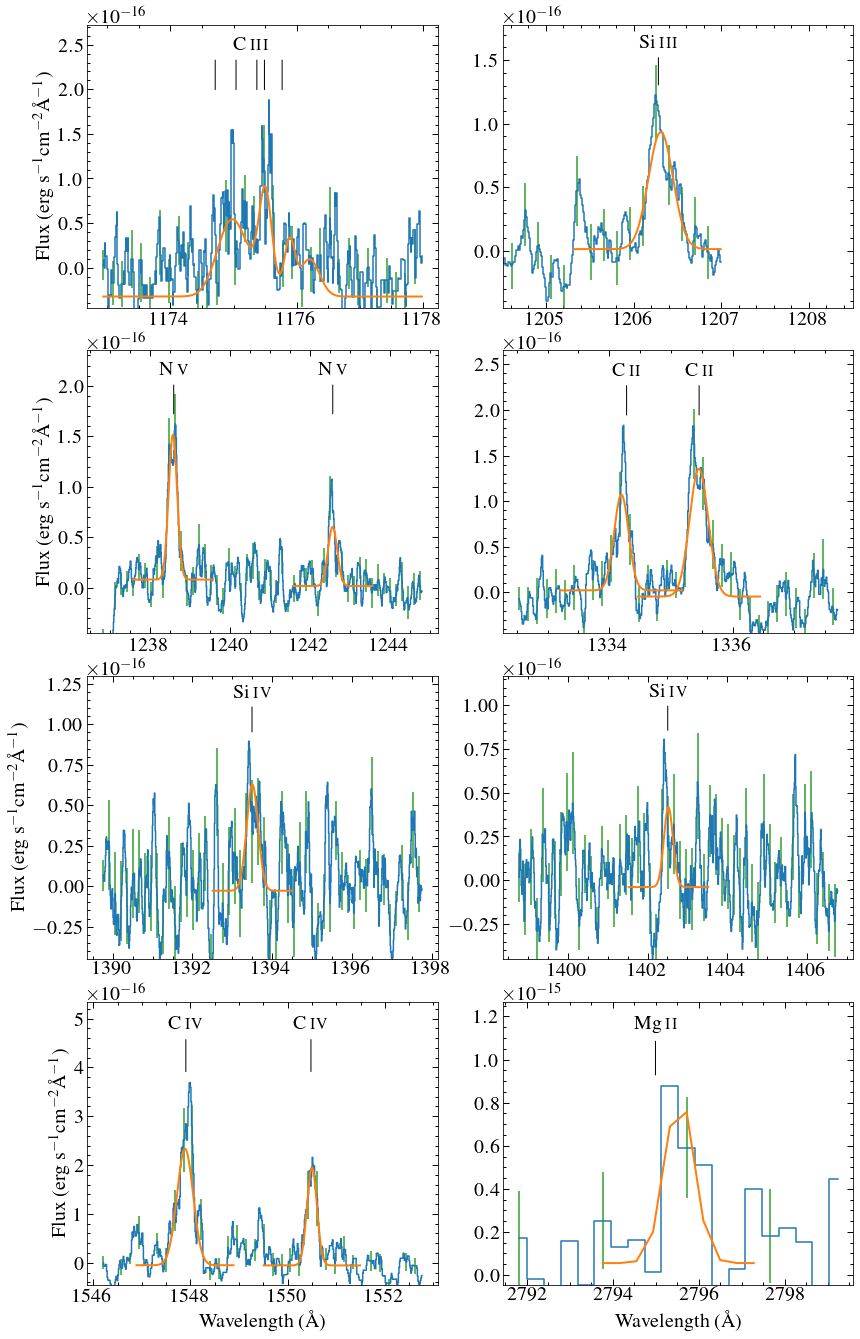

In [21]:
ciii_1175 = [1174.93,1175.26,1175.59,1175.71,1175.99]
siiii_1206 = [1206.51]
nv_1240 = [1238.821, 1242.804]
ci_1288 = [1288.918]
feii_1292 = [1292.405]
cii_1335 = [1334.532, 1335.708]
feii_1527 = [1527.2397] 
civ_1550 = [1548.195,1550.77]
mgii_2800 = [2795.528]

line_fluxes = []
line_errors = [] 

#sav_lines = detected_lines = [1206.51, 1238.821, 1242.804,
 #      1334.532, 1335.708, 1393.755, 1402.77 , 1548.195,
  #     1550.77, 2795.523] 

measured_lines = [ciii_1175, [1206.51], nv_1240, cii_1335, [1393.755], [1402.77], civ_1550, [2795.523]]
plot_name = np.array(['C\,{\sc iii}', 'Si\,{\sc iii}', 'N\,{\sc v}', 'C\,{\sc ii}', 'Si\,{\sc iv}','Si\,{\sc iv}',
                       'C\,{\sc iv}', 'Mg\,{\sc ii}'])  
params = Table.read('emision_lines_for_model.ecsv')
#print(params)

plt.figure(figsize=(12, 19))


for i, lineset in enumerate(measured_lines):
    line = lineset[0]
    if i == 1:
        line_mask = (w > line-4) & (w <1207)
    elif len(lineset) == 1:
        line_mask = (w > line-4) & (w < line+4)
    #elif i ==0:
     #   line_mask = (w > lineset[0]-4) & (w < lineset[-1]+4)
    
    else:
        line_mask = (w > lineset[0]-2) & (w < lineset[-1]+2)
    w1, f1, e1 = w[line_mask], f[line_mask], e[line_mask]
    smooth = 10
    if i == 0:
        smooth = 5 
    if i  < 7:
        f1 = convolve(f1,Box1DKernel(smooth))
        e1 = convolve(e1,Box1DKernel(smooth))/smooth**0.5
    #plt.figure(figsize=(5,5))
    plt.subplot(4, 2, i+1)
    plt.step(w1, f1, where='mid')
    estep =15
    if i ==7:
        estep=5
    plt.errorbar(w1[::estep], f1[::estep], yerr=e1[::estep], ls='none', c='C2', capsize=0)
   
  #  plt.axhline(0,c='k', ls='--') 
    gg_init = models.Const1D(0.0)
    if i == 0: 
        c_params = Table.read('ciii1176_lines_for_model.ecsv')
        a, m, s, o= c_params['Amplitude'], c_params['Mean'], c_params['Stddev'], c_params['Offset']
        mask = a > 0
        a, m, s, o = a[mask], m[mask], s[mask], o[mask]
        lines_mod = models.Const1D(o[0])

        for j in range(len(a)):
            lines_mod = lines_mod + models.Gaussian1D(a[j], m[j], s[j])
        plt.plot(w1, lines_mod(w1), c='C1', lw=2)
   
    else:
        width = 1
        if i ==7:
            width = 2
        for l in lineset:
            #print(l)
            ind = np.where(params['Line']==l)[0][0]
            #print(ind)
            a, m, s, o= params['Amplitude'][ind], params['Mean'][ind], params['Stddev'][ind], params['Offset'][ind]
            lines_mod = models.Const1D(o) + models.Gaussian1D(a, m, s)
            w2 = w1[(w1 >m-width) & (w1 < m+width)]
            plt.plot(w2, lines_mod(w2), c='C1', lw=2)
   # for li in lineset:
       
    #    plt.plot(w1,l(w1), lw=2)
        #minplot = -abs(f1[int(len(f1)/2)])*1.1
    plt.ylim(-0.45e-16, max(f1)*1.45)
    dv_lines = [dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value for line in lineset]
    #[plt.annotate(name,(line*dshift, top*1.05), xytext=(line*dshift, top*1.3), horizontalalignment='center') for name, line in zip(plot_name[nmask], lines[nmask])]
    [plt.annotate('',(dv_line, max(f1)*1.05), xytext=(dv_line, max(f1)*1.25),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for dv_line in dv_lines]
    name = plot_name[i]
    if i == 0:
        line = np.mean(lineset)
        dv_line = dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value
        plt.annotate(name,(dv_line, max(f1*1.05)), xytext=(dv_line, max(f1)*1.3), horizontalalignment='center')
    else:
        dv_lines = [dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value for line in lineset]
        [plt.annotate(name,(dv_line, max(f1*1.05)), xytext=(dv_line, max(f1)*1.3), horizontalalignment='center') for dv_line in dv_lines]
    if i  in (0, 2, 4, 6):
        plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
    if i in (6,7):
        plt.xlabel('Wavelength (\AA)')
    if i == 1:
        plt.xlim(line-2, line+2)
        #calculate flux
      

        
plt.tight_layout()
plt.subplots_adjust(hspace=0.15)
plt.savefig('../plots/t1_detected_lines.pdf', dpi=150)
                   


In [22]:
mlines = np.genfromtxt('phoenix_model_lines.txt', delimiter='\t', names=True, dtype=None,encoding=None)

Comparing predicted values from Peacock+19 with our values

In [23]:
"""\ion{C}{iii} & 1174.0 & $100.0\pm41.0$ \\ 
\ion{Si}{iii} & 1206.51 & $25.0\pm6.3$ \\ 
\ion{N}{v} & 1238.821 & $36.0\pm6.1$ \\ 
\ion{N}{v} & 1242.804 & $16.0\pm10.0$ \\ 
\ion{Si}{ii} & 1264.73 & $\leq4.2$ \\ 
\ion{Si}{ii} & 1298.95 & $4.4\pm3.5$ \\ 
\ion{Si}{ii} & 1309.28 & $5.7\pm2.6$ \\ 
\ion{C}{ii} & 1334.532 & $30.0\pm21.0$ \\ 
\ion{C}{ii} & 1335.708 & $55.0\pm19.0$ \\ 
\ion{C}{i} & 1351.657 & $\leq9.5$ \\ 
\ion{O}{i} & 1355.598 & $\leq14.0$ \\ 
\ion{O}{v} & 1371.292 & $\leq12.0$ \\ 
\ion{Fe}{ii} & 1391.08 & $\leq13.0$ \\ 
\ion{Si}{iv} & 1393.755 & $25.0\pm19.0$ \\ 
\ion{C}{i} & 1401.156 & $\leq7.5$ \\ 
\ion{Si}{iv} & 1402.77 & $14.0\pm7.6$ \\ 
\ion{Si}{ii} & 1526.71 & $\leq7.3$ \\ 
\ion{Si}{ii} & 1533.43 & $\leq15.0$ \\ 
\ion{C}{iv} & 1548.195 & $100.0\pm46.0$ \\ 
\ion{C}{iv} & 1550.77 & $53.0\pm17.0$ \\ 
\ion{C}{i} & 1561.0 & $\leq18.0$ \\ 
\ion{He}{ii} & 1643.0 & $\leq26.0$ \\ 
\ion{O}{iii} & 1666.153 & $\leq35.0$ \\ 
\ion{Al}{ii} & 1670.787 & $\leq45.0$ \\ 
\ion{Al}{i} & 1766.39 & $\leq71.0$ \\ 
\ion{Mg}{ii} & 2795.523 & $620.0\pm29.0$ \\ 
\ion{Mg}{ii} & 2802.697 & $\leq340.0$ \"""

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-23-2d1c896597d9>, line 27)

In [ ]:
pmes = np.array([4.2,4.4,5.6,(55+30),13,7.3,15,(100+53), 45, 71,620,340,380, 790])
perr = np.array([0,3.5,2.6,(21**2+19**2)**0.5,0,0,0,(46**2+17**2)**0.5, 0,0,30,0, 100, 0])
pmask = [True, True, False, False,False, True,True,True,True,True, True,True,True,True,True, True, True]
ptab = mlines[pmask]

tforms = np.array([4.5, 4.7, 4.52, 4.3, 5.0, 4.32, 4.48, 4.98, 4.54, 4.46, 4.22, 4.2, 3.5, 3.6])
def plot_ratio(pmes, perr, model, colour, xaxis):
    args = np.argsort(xaxis)
    upmask = (perr[args] > 0)
    ratio = ptab[model][args]/pmes[args]
    error = ratio * (perr[args]/pmes[args])
    plt.errorbar(xaxis[args], ratio , yerr=0, c=colour, ls='--')
    plt.errorbar(xaxis[args][upmask], ratio[upmask], yerr=error[upmask], ls='none', marker='x', c=colour, label=model.replace('_',' '))
    plt.errorbar(xaxis[args][~upmask], ratio[~upmask], yerr=ratio[~upmask]*0.5, ls='none', marker='x', uplims=True,c=colour)

plt.figure(figsize=(18,6))
plt.subplot(121)



#pnames = ptab['Species'][args]
pnames = np.array(['Fe II', 'Mg II', '', 'C II', 'Si II', 'Al I', 'Si II','', '', 'Al II', 'Si III', 'C IV'])
shifts = [0, 0, 300, 0, 300, 0, 300,400,450,0,0,0]
#[plt.annotate(n, (loc, 200-shift/10), xytext=(loc, 500-shift), horizontalalignment='center',arrowprops=dict(arrowstyle='-')) for n, loc, shift in zip(pnames, tforms[args], shifts)]

    
plot_ratio(pmes, perr, 'Model_1A','C0', tforms)
plot_ratio(pmes, perr, 'Model_2A','C1', tforms)
plot_ratio(pmes, perr, 'Model_2B','C2', tforms)
plt.axhline(1, ls='--', c='k')
plt.ylim(3e-4, 9e1)
#plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('log (Formation Temperature)')
plt.ylabel('$F_{\mathrm{mod}}/F_{\mathrm{obs}}$', size=20)
plt.xticks((3.5, 4.0, 4.5, 5.0), ('3.5', '4.0', '4.5', '?'))



plt.subplot(122)   
plot_ratio(pmes, perr, 'Model_1A','C0', ptab['lambda_angst'])
plot_ratio(pmes, perr, 'Model_2A','C1', ptab['lambda_angst'])
plot_ratio(pmes, perr, 'Model_2B','C2', ptab['lambda_angst'])
plt.xscale('log')
plt.yscale('log')
plt.axhline(1, ls='--', c='k')
plt.ylim(3e-4, 9e1)
plt.xlabel('Wavelength (\AA)')

#plt.errorbar(ptab['lambda_angst'][upmask], pmes[upmask], yerr=perr[upmask], ls='none', marker='o')
#plt.errorbar(ptab['lambda_angst'][~upmask], pmes[~upmask], yerr=5, ls='none', marker='o', uplims=True)
#plt.errorbar(ptab['lambda_angst'], ptab['Model_1A'], yerr=0,  marker='o')
#plt.errorbar(ptab['lambda_angst'], ptab['Model_2A'], yerr=0,  marker='o')
#plt.errorbar(ptab['lambda_angst'], ptab['Model_2B'], yerr=0,  marker='o')

plt.tight_layout()
plt.savefig('../plots/phoenix_v_cos_tform.pdf', dpi=150)